In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch

In [2]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right, TB = Top to Bottom

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad ), shape='record')
        if n._op:
            # if this value is result of some operation , create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 node to op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

### - Breaking up a `tanh` function
### - Adding more operations

In [3]:
class Value:
    
    def __init__( self, data, _children=(), _operation='', label='' ):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _operation
        self._backward = lambda: None 
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, otherObj):
        # Ensure that `otherObj` is of type `Value`, 
        # if not, create a new `Value` object with `otherObj` as its value
        otherObj = otherObj if isinstance(otherObj, Value) else Value(otherObj)
        out = Value(self.data + otherObj.data, (self, otherObj), '+' )
        def _backward():
            self.grad += 1.0 * out.grad
            otherObj.grad += 1.0 * out.grad
        out._backward = _backward 
        return out
    
    def __mul__(self, otherObj):
        # Ensure that `otherObj` is of type `Value`, 
        # if not, create a new `Value` object with `otherObj` as its value
        otherObj = otherObj if isinstance(otherObj, Value) else Value(otherObj)
        out = Value(self.data * otherObj.data, (self, otherObj), '*')
        def _backward():
            self.grad += otherObj.data * out.grad
            otherObj.grad += self.data * out.grad
        out._backward = _backward 
        return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ),'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward 
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0 
        for node in reversed(topo):
            node._backward()

In [4]:
a = Value(5)
b = Value(10)
print(a+b)

Value(data=15)


In [5]:
print(a + 10)
print(a + 4582)

Value(data=15)
Value(data=4587)


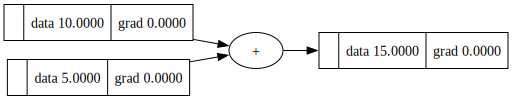

In [6]:
draw_dot(a + b)

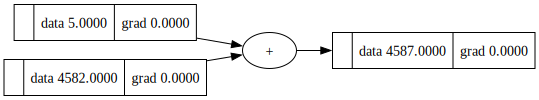

In [7]:
draw_dot(a + 4582 )

Value(data=25)


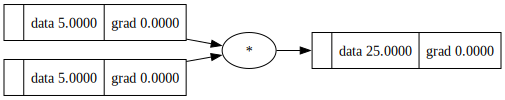

In [8]:
print(a * 5)
draw_dot(a*5)

In [9]:
# reverse doesn't work
# 5 * a

# TypeError: unsupported operand type(s) for *: 'int' and 'Value'

### Special Methods for Arithmetic Operations in Python

Python provides special methods, often referred to as "magic methods" or "dunder methods" (short for "double underscore"), to define the behavior of built-in operators like addition (`+`), multiplication (`*`), etc., for user-defined objects. These methods enable custom objects to support arithmetic operations seamlessly.

#### Right-Hand Arithmetic Operations:

1. **`__radd__(self, other)`**: This method defines the behavior of the right-hand addition operation (`+`) when the left operand does not support the operation. It is called when the object appears on the right side of the `+` operator.
   
2. **`__rsub__(self, other)`**: Defines the behavior of the right-hand subtraction operation (`-`).

3. **`__rmul__(self, other)`**: Defines the behavior of the right-hand multiplication operation (`*`).

4. **`__rdiv__(self, other)`**: Defines the behavior of the right-hand division operation (`/`).

5. **`__rmod__(self, other)`**: Defines the behavior of the right-hand modulo operation (`%`).

#### Right-Hand Arithmetic Operations:

1. **`__rmul__(self, otherObj)`**: This method defines the behavior of the right-hand multiplication operation (`*`). It is called when the object appears on the right side of the `*` operator, and the left operand does not support the operation.

2. **`__mul__(self, otherObj)`**: This method defines the behavior of the left-hand multiplication operation (`*`). It is called when the object appears on the left side of the `*` operator, or when both operands support the operation.

#### Usage Example:

```python
class Value:
    def __init__(self, data):
        self.data = data

    def __rmul__(self, otherObj):
        return Value(self.data * otherObj)

    def __mul__(self, otherObj):
        return Value(self.data * otherObj)

a = Value(5)
b = 3

result1 = a * b  # Calls a.__mul__(b), returns a new instance of Value with data 15
result2 = b * a  # Calls a.__rmul__(b), returns a new instance of Value with data 15

print(result1.data)  # Output: 15
print(result2.data)  # Output: 15
```

---

In [10]:
class Value:
    
    def __init__( self, data, _children=(), _operation='', label='' ):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _operation
        self._backward = lambda: None 
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, otherObj):
        otherObj = otherObj if isinstance(otherObj, Value) else Value(otherObj)
        out = Value(self.data + otherObj.data, (self, otherObj), '+' )
        def _backward():
            self.grad += 1.0 * out.grad
            otherObj.grad += 1.0 * out.grad
        out._backward = _backward 
        return out
    
    # Right-Hand Arithmetic Operation
    def __radd__(self, otherObj):
        return self+otherObj
    
    def __mul__(self, otherObj):
        otherObj = otherObj if isinstance(otherObj, Value) else Value(otherObj)
        out = Value(self.data * otherObj.data, (self, otherObj), '*')
        def _backward():
            self.grad += otherObj.data * out.grad
            otherObj.grad += self.data * out.grad
        out._backward = _backward 
        return out
    
    # Right-Hand Arithmetic Operation
    def __rmul__(self, otherObj):
        return self*otherObj
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ),'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward 
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0 
        for node in reversed(topo):
            node._backward()

In [11]:
a = Value(5)
print(a + 4582)
print(4582 + a)

Value(data=4587)
Value(data=4587)


In [12]:
a = Value(5)
print(a * 10)
print(10 * a)

Value(data=50)
Value(data=50)


---

### Understanding the Hyperbolic Tangent (tanh) Function

The hyperbolic tangent function, often denoted as \\( \text{tanh}(x) \\), is a fundamental component in machine learning, particularly in neural networks. It serves as an activation function, transforming input values into a bounded output range.

#### Function Definition:
The tanh function is defined mathematically as:

\\[ \text{tanh}(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} = \frac{e^{2x} - 1}{e^{2x} + 1}\\]


---

### Updating Value: adding exponentiation using Euler's number e

In [13]:
class Value:
    
    def __init__( self, data, _children=(), _operation='', label='' ):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _operation
        self._backward = lambda: None 
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, otherObj):
        otherObj = otherObj if isinstance(otherObj, Value) else Value(otherObj)
        out = Value(self.data + otherObj.data, (self, otherObj), '+' )
        def _backward():
            self.grad += 1.0 * out.grad
            otherObj.grad += 1.0 * out.grad
        out._backward = _backward 
        return out
    
    def __radd__(self, otherObj):
        return self+otherObj
    
    def __mul__(self, otherObj):
        otherObj = otherObj if isinstance(otherObj, Value) else Value(otherObj)
        out = Value(self.data * otherObj.data, (self, otherObj), '*')
        def _backward():
            self.grad += otherObj.data * out.grad
            otherObj.grad += self.data * out.grad
        out._backward = _backward 
        return out
    
    def __rmul__(self, otherObj):
        return self*otherObj

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ),'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward 
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0 
        for node in reversed(topo):
            node._backward()

In [14]:
a= Value(2)

In [15]:
a.exp()

Value(data=7.38905609893065)

In [16]:
2.71828**2

7.3890461584

In [17]:
b = Value(5)
print(a, b)

Value(data=2) Value(data=5)


In [18]:
a, b

(Value(data=2), Value(data=5))

---
---

### division of Values

In [19]:
# a / b

# TypeError: unsupported operand type(s) for /: 'Value' and 'Value'

### all operations are same
- a / b
- a * (1/b)
- a * (b**-1) 
#### we need power operation `**` and subtraction operation `-` as well 
- `a - b` is same as `a + (-b)`

In [20]:
x = 10
y = 4

print(x/y)
print(x* (1/y))
print(x * (y)**-1)

2.5
2.5
2.5


### Understanding the `assert` Statement in Python

The `assert` statement is a powerful tool in Python used to debug code and ensure that certain conditions are met during program execution. It allows you to quickly verify assumptions about your code and catch potential errors early in the development process.

#### Syntax:

The syntax of the `assert` statement is simple:

```python
assert condition, message
x = 10
assert x > 0, "Value of x must be positive"



In [21]:
class Value:
    
    def __init__( self, data, _children=(), _operation='', label='' ):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _operation
        self._backward = lambda: None 
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, otherObj):
        otherObj = otherObj if isinstance(otherObj, Value) else Value(otherObj)
        out = Value(self.data + otherObj.data, (self, otherObj), '+' )
        def _backward():
            self.grad += 1.0 * out.grad
            otherObj.grad += 1.0 * out.grad
        out._backward = _backward 
        return out
    
    def __radd__(self, otherObj):
        return self+otherObj
    
    # -self
    def __neg__(self): 
        # here we are using multiplication method for subtraction
        return self * (-1)
    
    # self - otherObj
    def __sub__(self, otherObj):
        # here we are using addition and negation method for subtraction
        return self + (-otherObj)
    
    def __mul__(self, otherObj):
        otherObj = otherObj if isinstance(otherObj, Value) else Value(otherObj)
        out = Value(self.data * otherObj.data, (self, otherObj), '*')
        def _backward():
            self.grad += otherObj.data * out.grad
            otherObj.grad += self.data * out.grad
        out._backward = _backward 
        return out
    
    # otherObj * self
    def __rmul__(self, otherObj): 
        return self*otherObj
    
    # self/otherObj
    def __truediv__(self, otherObj): 
        return self * (otherObj**(-1))
    
    # self**otherObj
    def __pow__(self, otherObj): 
        assert isinstance(otherObj, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** otherObj, (self, ), f"**{otherObj}")
        def _backward():
             self.grad += (otherObj * self.data**(otherObj-1)) * out.grad
        out._backward = _backward 
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ),'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward 
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward 
        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0 
        for node in reversed(topo):
            node._backward()

In [22]:
a = Value(2.0)
b = Value(4.0)
print(a/b)

Value(data=0.5)


In [23]:
print(a*(b**-1))

Value(data=0.5)


In [24]:
print(a)
print(-a)

Value(data=2.0)
Value(data=-2.0)


In [25]:
print(a-b)

Value(data=-2.0)


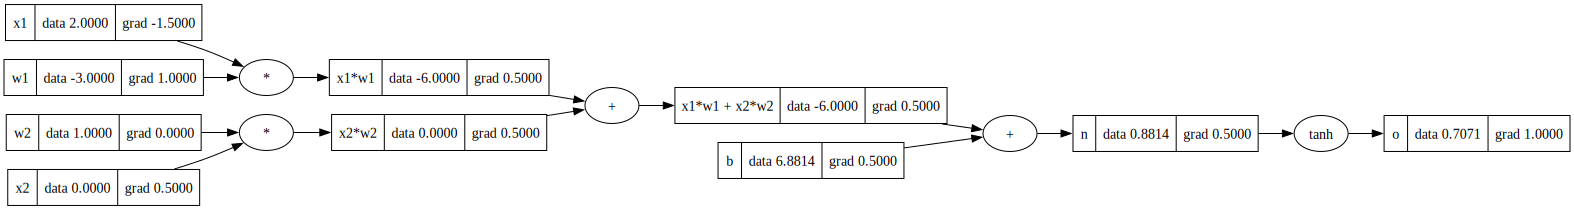

In [26]:
# Inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

o = n.tanh(); o.label='o'
o.backward()
draw_dot(o)

---

The tanh function is defined mathematically as:

\\[ \text{tanh}(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} = \frac{e^{2x} - 1}{e^{2x} + 1}\\]

---

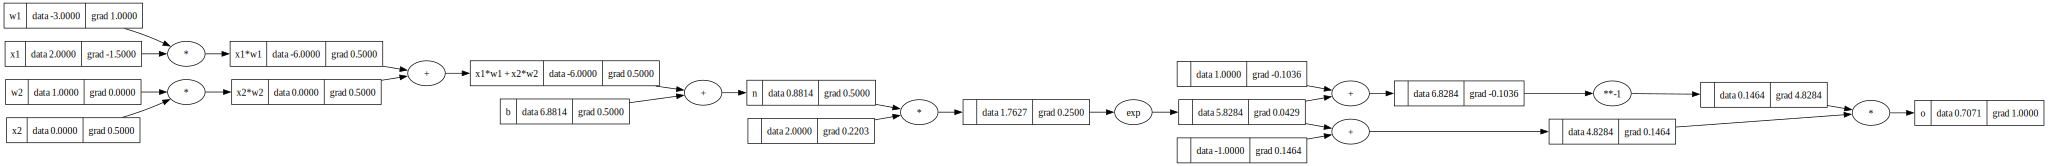

In [27]:
# Inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

# ----------------------
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----------------------

o.label='o'
o.backward()
draw_dot(o)

### Doing the same thing but in PyTorch

# PyTorch: Deep Learning Framework

PyTorch is an open-source machine learning library primarily developed by Facebook's AI Research lab (FAIR). It provides a flexible and dynamic deep learning framework for building and training neural networks.

## Key Features:

1. **Tensor Computation**: PyTorch provides multi-dimensional arrays called tensors, similar to NumPy arrays but with additional GPU acceleration support for faster computation. Tensors in PyTorch can be easily manipulated and used for numerical computations.

2. **Automatic Differentiation**: PyTorch offers automatic differentiation through its `autograd` package, allowing gradients to be computed automatically for tensor operations. This feature simplifies the process of implementing and training neural networks by automatically calculating gradients for backpropagation.

3. **Dynamic Computational Graphs**: Unlike some other deep learning frameworks that use static computational graphs, PyTorch uses dynamic computational graphs. This means that the computational graph is built on-the-fly during execution, allowing for more flexibility and easier debugging.

4. **Neural Network Building Blocks**: PyTorch provides a rich set of tools and modules for building neural networks, including layers, activation functions, optimization algorithms, loss functions, and more. It also offers a high-level neural network module called `torch.nn` for building complex architectures with ease.

5. **GPU Acceleration**: PyTorch supports seamless integration with GPUs, enabling accelerated training of deep neural networks on compatible hardware. This GPU acceleration significantly speeds up the training process for large-scale models.

6. **Community and Ecosystem**: PyTorch has a vibrant community of developers and researchers contributing to its development. It also offers extensive documentation, tutorials, and resources, making it accessible to both beginners and experienced practitioners.

PyTorch has gained popularity among researchers and practitioners in the machine learning and deep learning communities due to its flexibility, ease of use, and powerful capabilities for building and training neural networks.


In [28]:
import torch

In [29]:
element1 = torch.Tensor([1.3])
element1

tensor([1.3000])

In [30]:
element1.data

tensor([1.3000])

In [31]:
element1.data.item()

1.2999999523162842

In [32]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)
x_data

tensor([[1, 2],
        [3, 4]])

In [33]:
x_data.dtype

torch.int64

In [34]:
x_data + x_data

tensor([[2, 4],
        [6, 8]])

In [35]:
x_data * x_data 

tensor([[ 1,  4],
        [ 9, 16]])

In [36]:
x_data - x_data 

tensor([[0, 0],
        [0, 0]])

In [37]:
x_data.data

tensor([[1, 2],
        [3, 4]])

In [38]:
y_data = torch.Tensor([[[1,2,3,4],[9,7,8,6]],[[11,21,31,12], [86,78,98,75]]])
y_data

tensor([[[ 1.,  2.,  3.,  4.],
         [ 9.,  7.,  8.,  6.]],

        [[11., 21., 31., 12.],
         [86., 78., 98., 75.]]])

In [39]:
y_data - y_data

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.]]])

In [40]:
y_data + y_data

tensor([[[  2.,   4.,   6.,   8.],
         [ 18.,  14.,  16.,  12.]],

        [[ 22.,  42.,  62.,  24.],
         [172., 156., 196., 150.]]])

In [41]:
y_data * y_data

tensor([[[1.0000e+00, 4.0000e+00, 9.0000e+00, 1.6000e+01],
         [8.1000e+01, 4.9000e+01, 6.4000e+01, 3.6000e+01]],

        [[1.2100e+02, 4.4100e+02, 9.6100e+02, 1.4400e+02],
         [7.3960e+03, 6.0840e+03, 9.6040e+03, 5.6250e+03]]])

In [42]:
y_data.dtype

torch.float32

In [43]:
y_data.double().dtype

torch.float64

---
---
---

In [44]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b  = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad  = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()


print("---"*5)
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
---------------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


Therefore it is proved that our previous gradients were correct

In [45]:
print(o)
print(o.data.item())

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)
0.7071066904050358


In [46]:
print(x1.grad)
print(x1.grad.item())

tensor([-1.5000], dtype=torch.float64)
-1.5000003851533106


---
#
#
---
#
#
---